**Tutorial 8 - Markov Chain Monte Carlo**

In this tutorial we will learn how to construct a basic Metropolis-Hastings Markov Chain sampler and apply it to supernova data.


In [2]:
# 1) Make a Metropolis-Hastings stepping function.
#
# The function should take the following inputs 
# x - the current position in parameter space
# loglike - the value of the log of the likelihood 
#           evaluated at x
# loglike_func - a function that returns to log of the 
#            likelihood given a position in parameters space
# proposal_func - a proposal function that takes a position in 
#                  parameter space and proposes another
#
# The function should return the updated position, the updated 
# loglike and a boolean that is True if the proposed step was 
# accepted and False if it wasn't. 
# You can assume the proposal function is symmetric.

import pandas as pa
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand

def MH_step(x, loglike, loglike_func, proposal_func):
    x_prop = proposal_func(x)
    if x_prop[1] < 0 or x_prop[1] > 1:
        x_prop=x
    
    loglike_prop = loglike_func(x_prop)
    
    if np.exp(loglike_prop-loglike) < 1. :
        a = np.exp(loglike_prop-loglike)
    else:
        a=1
    
    number = rand.uniform(0.0, 1.0)
    
    if number < a:
        x_step = x_prop
        loglike_step = loglike_prop
        step = True
    else:
        x_step = x
        loglike_step = loglike
        step = False
    
    return x_step, loglike_step, step


In [3]:
# 2) Complete this code for a Gaussian proposal function class

class gaussian_transfer_function :
    
    ## This part is the constructor and 
    ## sets the internal information in the object
    # that is declared with
    # "func = gaussian_transfer_function(sigma_vector)"
    def __init__(self, sigma):
        self.n = len(sigma)
        self.s = sigma
    ##  This part defines what happens when 
    ##  you do "y = func(x)"
    ##  This should return a new point
    def __call__(self,x):    
        return rand.normal(x, self.s)


In [4]:
# 3) Make a Gaussian likelihood class of the form

class LogGaussianLikelihood :
    def __init__(self,y_data,x_data,y_model,sigma):
        
        self.yd = y_data
        self.xd = x_data
        self.ym = y_model
        self.s = sigma
             
#    
#         store the data, model and errors in the object
#         The function y_model(params,x_data) will return the 
#         predicted value for y to be compared to y_data
#
    def __call__(self,params):
        return -0.5 * np.sum(((self.yd-self.ym(params, self.xd))/self.s)**2)
                   
#   
#        Using the stored data and model to calculate 
#        the log of the Gaussian likelihood and return 
#        its value.
#        

4) Write a function that returns the distance modulus with 
signature def mu_model(p,z). 

parameters p are 

p[0] is the absolute magnitude normalization 

p[1] is omega_matter.  

Use the library function 
astropy.cosmology.FlatLambdaCDM.luminosity_distance(z).value 
to calculate the luminosity distance.


In [5]:
import astropy.cosmology as cosmo

def mu_model(p,z):
    univ = cosmo.FlatLambdaCDM(H0=70.0, Om0=p[1])
    return 5*np.log10(univ.luminosity_distance(z).value) + p[0]

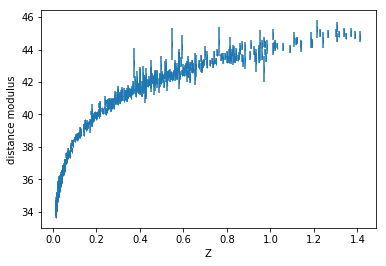

In [6]:
# Read in the supernova data
#
data = pa.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')

z = data['redshift']
mu = data['dist_mod']
mu_err = data['dist_mod_error']

plt.errorbar(z,mu,yerr=mu_err,fmt='|')
plt.xlabel('Z')
plt.ylabel('distance modulus')
plt.show()

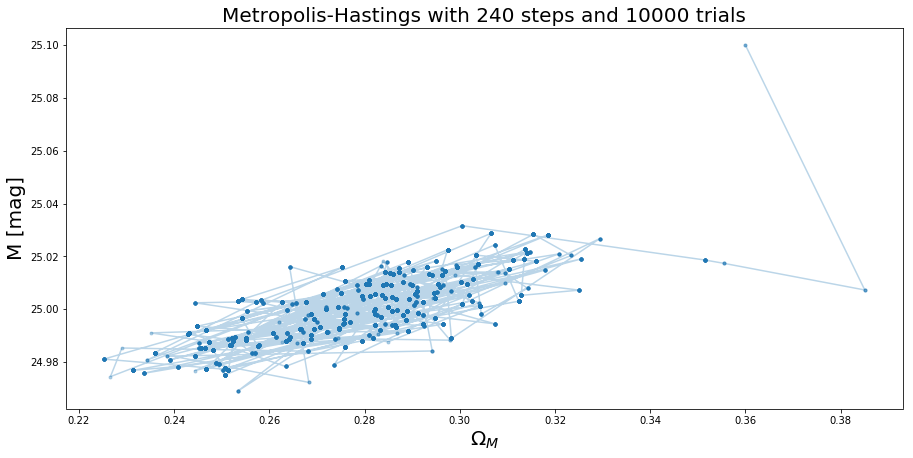

In [27]:
# 5) 
## Make an instance of LogGaussianLikelihood with the data.
## Call it loglike_func

loglike_func = LogGaussianLikelihood(mu, z, mu_model, mu_err)

## Make an instance of gaussian_transfer_function

prop_func = gaussian_transfer_function([0.2, 0.05])

## Set up the initial point p[] and its log likelihood 
p = [25.1, 0.36]
loglike = loglike_func(p)
## using  loglike_func(p)

## Make an MCMC loop 1000 steps or more long and make a scatter plot of 
## the chain.  Record the acceptance fraction.
N=10000
nsteps = 0
ntot=0
omega=np.empty(N)
mag=np.empty(N)
bul=np.empty(N)


for i in range(N):
    
    p, loglike, step = MH_step(p, loglike, loglike_func, prop_func)
    
    #if step == True:
    mag[i] = p[0]
    omega[i] = p[1]
        #print(mag[nsteps], omega[nsteps])
    if step == True:
        nsteps += 1
    ntot += 1

#print(len(omega))
plt.figure(figsize=(15, 7))
plt.plot(omega, mag, marker='.', alpha=0.3)
plt.xlabel(r'$\Omega_M$', size=20)
plt.ylabel('M [mag]', size=20)
plt.title('Metropolis-Hastings with %s steps and %s trials' %(nsteps, ntot), size=20)
plt.show()



6) Make historgrams of the two parameters.

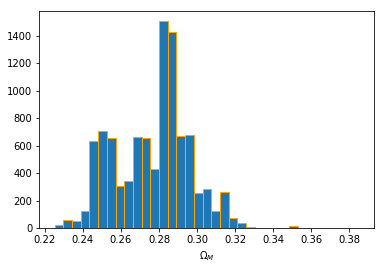

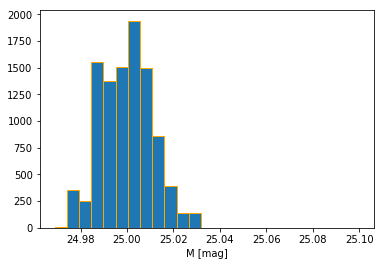

In [28]:
plt.hist(omega, bins=35, edgecolor='orange')
plt.xlabel(r'$\Omega_M$')
plt.show()

plt.hist(mag, bins=25, edgecolor='orange')
plt.xlabel(r'M [mag]')
plt.show()

7) Use numpy.histogram2d() to make a 2 dimensional of the chain.



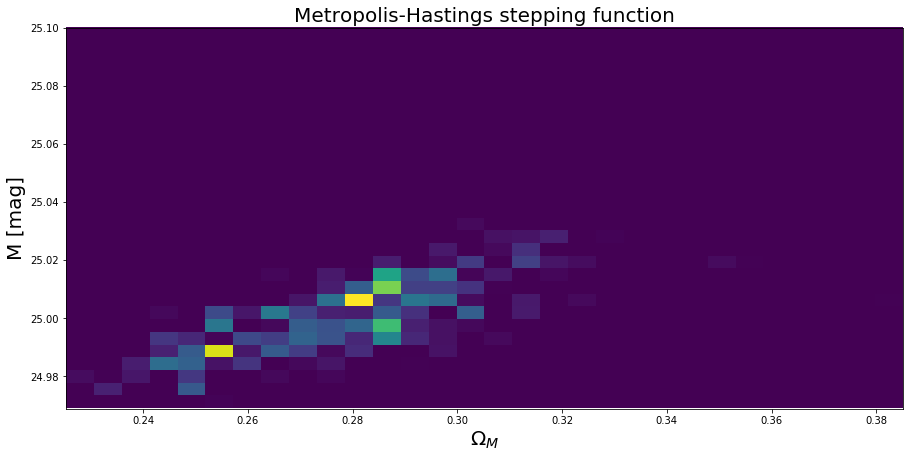

In [29]:
plt.figure(figsize=(15, 7))
plt.hist2d(omega, mag, bins=30)
plt.xlabel(r'$\Omega_M$', size=20)
plt.ylabel('M [mag]', size=20)
plt.title('Metropolis-Hastings stepping function', size=20)
plt.show()


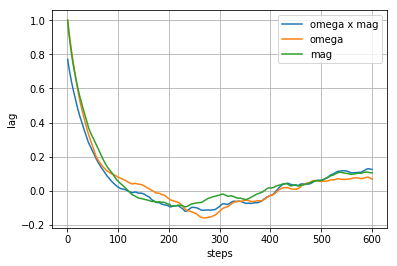

In [30]:
## 8) Use this function to estimate the correlation length 
## of your chain. Plot the autocorrelation function for 
## lag zero to a few hundred.
def corrfunction(x,y):
    '''
    This function calculates the correlation coefficient 
    as a function of lag between 
    '''
    xc = x - np.mean(x)
    yc = y - np.mean(y)
    
    N = len(x)
    out = np.empty(N-2)
    stdx = np.std(xc)
    stdy = np.std(yc)

    for i in range(N-2) :
        xt = xc[0:N-i]
        yt = yc[i:N]
        if(stdx == 0 or stdy == 0):  ## this can happen for last elements
            out[i] = 0
        else :
            out[i] = np.mean(xt*yt)/stdx/stdy

    return out


corr=corrfunction(omega, mag)
corro=corrfunction(omega, omega)
corrm=corrfunction(mag, mag)
steps=np.empty(600)
corr1=np.empty(600)
corr2=np.empty(600)
corr3=np.empty(600)
for i in range(600):
    steps[i]=i+1
    corr1[i]=corr[i]
    corr2[i]=corro[i]
    corr3[i]=corrm[i]
    
plt.plot(steps, corr1, label='omega x mag')
plt.plot(steps, corr2, label='omega')
plt.plot(steps, corr3, label='mag')
plt.xlabel('steps')
plt.ylabel('lag')
plt.grid()
plt.legend()
plt.show()

8) Calculate the mean, variance and covariance of the parameters.

In [31]:
omega_mean = np.mean(omega)
omega_var = np.var(omega)
mag_mean = np.mean(mag)
mag_var = np.var(mag)

cov = np.cov(omega, mag)

print('OmegaM: mean=%.4f var=%.4f') %(omega_mean, omega_var)
print('M [mag]: mean=%.4f var=%.4f') %(mag_mean, mag_var)
print('The correlation beetwen OmegaM and M is %.5f') %(cov[0][1])

OmegaM: mean=0.2770 var=0.0004
M [mag]: mean=25.0001 var=0.0001
The correlation beetwen OmegaM and M is 0.00017
